# load library

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install torchtext==0.9.1

In [3]:
cd /content/drive/MyDrive/kfashion_attribute_model

/content/drive/MyDrive/kfashion_attribute_model


In [31]:
#torch
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#numpy
import numpy as np

#model
from layers import *

from resnest import *
from resnet import ResNet

#utility
from helpers import build_model_with_cfg
import math
from urllib.request import urlretrieve
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt


# define transform utility

In [23]:
class Warp(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = int(size)
        self.interpolation = interpolation

    def __call__(self, img):
        return img.resize((self.size, self.size), self.interpolation)

    def __str__(self):
        return self.__class__.__name__ + ' (size={size}, interpolation={interpolation})'.format(size=self.size,
                                                                                                interpolation=self.interpolation)
class MultiScaleCrop(object):

    def __init__(self, input_size, scales=None, max_distort=1, fix_crop=True, more_fix_crop=True):
        self.scales = scales if scales is not None else [1, 875, .75, .66]
        self.max_distort = max_distort
        self.fix_crop = fix_crop
        self.more_fix_crop = more_fix_crop
        self.input_size = input_size if not isinstance(input_size, int) else [input_size, input_size]
        self.interpolation = Image.BILINEAR

    def __call__(self, img):
        im_size = img.size
        crop_w, crop_h, offset_w, offset_h = self._sample_crop_size(im_size)
        crop_img_group = img.crop((offset_w, offset_h, offset_w + crop_w, offset_h + crop_h))
        ret_img_group = crop_img_group.resize((self.input_size[0], self.input_size[1]), self.interpolation)
        return ret_img_group

    def _sample_crop_size(self, im_size):
        image_w, image_h = im_size[0], im_size[1]

        # find a crop size
        base_size = min(image_w, image_h)
        crop_sizes = [int(base_size * x) for x in self.scales]
        crop_h = [self.input_size[1] if abs(x - self.input_size[1]) < 3 else x for x in crop_sizes]
        crop_w = [self.input_size[0] if abs(x - self.input_size[0]) < 3 else x for x in crop_sizes]

        pairs = []
        for i, h in enumerate(crop_h):
            for j, w in enumerate(crop_w):
                if abs(i - j) <= self.max_distort:
                    pairs.append((w, h))

        crop_pair = random.choice(pairs)
        if not self.fix_crop:
            w_offset = random.randint(0, image_w - crop_pair[0])
            h_offset = random.randint(0, image_h - crop_pair[1])
        else:
            w_offset, h_offset = self._sample_fix_offset(image_w, image_h, crop_pair[0], crop_pair[1])

        return crop_pair[0], crop_pair[1], w_offset, h_offset

    def _sample_fix_offset(self, image_w, image_h, crop_w, crop_h):
        offsets = self.fill_fix_offset(self.more_fix_crop, image_w, image_h, crop_w, crop_h)
        return random.choice(offsets)

    @staticmethod
    def fill_fix_offset(more_fix_crop, image_w, image_h, crop_w, crop_h):
        w_step = (image_w - crop_w) // 4
        h_step = (image_h - crop_h) // 4

        ret = list()
        ret.append((0, 0))  # upper left
        ret.append((4 * w_step, 0))  # upper right
        ret.append((0, 4 * h_step))  # lower left
        ret.append((4 * w_step, 4 * h_step))  # lower right
        ret.append((2 * w_step, 2 * h_step))  # center

        if more_fix_crop:
            ret.append((0, 2 * h_step))  # center left
            ret.append((4 * w_step, 2 * h_step))  # center right
            ret.append((2 * w_step, 4 * h_step))  # lower center
            ret.append((2 * w_step, 0 * h_step))  # upper center

            ret.append((1 * w_step, 1 * h_step))  # upper left quarter
            ret.append((3 * w_step, 1 * h_step))  # upper right quarter
            ret.append((1 * w_step, 3 * h_step))  # lower left quarter
            ret.append((3 * w_step, 3 * h_step))  # lower righ quarter

        return ret


    def __str__(self):
        return self.__class__.__name__


def download_url(url, destination=None, progress_bar=True):
    """Download a URL to a local file.

    Parameters
    ----------
    url : str
        The URL to download.
    destination : str, None
        The destination of the file. If None is given the file is saved to a temporary directory.
    progress_bar : bool
        Whether to show a command-line progress bar while downloading.

    Returns
    -------
    filename : str
        The location of the downloaded file.

    Notes
    -----
    Progress bar use/example adapted from tqdm documentation: https://github.com/tqdm/tqdm
    """

    def my_hook(t):
        last_b = [0]

        def inner(b=1, bsize=1, tsize=None):
            if tsize is not None:
                t.total = tsize
            if b > 0:
                t.update((b - last_b[0]) * bsize)
            last_b[0] = b

        return inner

    if progress_bar:
        with tqdm(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
            filename, _ = urlretrieve(url, filename=destination, reporthook=my_hook(t))
    else:
        filename, _ = urlretrieve(url, filename=destination)


class AveragePrecisionMeter(object):
    """
    The APMeter measures the average precision per class.
    The APMeter is designed to operate on `NxK` Tensors `output` and
    `target`, and optionally a `Nx1` Tensor weight where (1) the `output`
    contains model output scores for `N` examples and `K` classes that ought to
    be higher when the model is more convinced that the example should be
    positively labeled, and smaller when the model believes the example should
    be negatively labeled (for instance, the output of a sigmoid function); (2)
    the `target` contains only values 0 (for negative examples) and 1
    (for positive examples); and (3) the `weight` ( > 0) represents weight for
    each sample.
    """

    def __init__(self, difficult_examples=False):
        super(AveragePrecisionMeter, self).__init__()
        self.reset()
        self.difficult_examples = difficult_examples

    def reset(self):
        """Resets the meter with empty member variables"""
        self.scores = torch.FloatTensor(torch.FloatStorage())
        self.targets = torch.LongTensor(torch.LongStorage())

    def add(self, output, target):
        """
        Args:
            output (Tensor): NxK tensor that for each of the N examples
                indicates the probability of the example belonging to each of
                the K classes, according to the model. The probabilities should
                sum to one over all classes
            target (Tensor): binary NxK tensort that encodes which of the K
                classes are associated with the N-th input
                    (eg: a row [0, 1, 0, 1] indicates that the example is
                         associated with classes 2 and 4)
            weight (optional, Tensor): Nx1 tensor representing the weight for
                each example (each weight > 0)
        """
        if not torch.is_tensor(output):
            output = torch.from_numpy(output)
        if not torch.is_tensor(target):
            target = torch.from_numpy(target)

        if output.dim() == 1:
            output = output.view(-1, 1)
        else:
            assert output.dim() == 2, \
                'wrong output size (should be 1D or 2D with one column \
                per class)'
        if target.dim() == 1:
            target = target.view(-1, 1)
        else:
            assert target.dim() == 2, \
                'wrong target size (should be 1D or 2D with one column \
                per class)'
        if self.scores.numel() > 0:
            assert target.size(1) == self.targets.size(1), \
                'dimensions for output should match previously added examples.'

        # make sure storage is of sufficient size
        if self.scores.storage().size() < self.scores.numel() + output.numel():
            new_size = math.ceil(self.scores.storage().size() * 1.5)
            self.scores.storage().resize_(int(new_size + output.numel()))
            self.targets.storage().resize_(int(new_size + output.numel()))

        # store scores and targets
        offset = self.scores.size(0) if self.scores.dim() > 0 else 0
        self.scores.resize_(offset + output.size(0), output.size(1))
        self.targets.resize_(offset + target.size(0), target.size(1))
        self.scores.narrow(0, offset, output.size(0)).copy_(output)
        self.targets.narrow(0, offset, target.size(0)).copy_(target)

    def value(self):
        """Returns the model's average precision for each class
        Return:
            ap (FloatTensor): 1xK tensor, with avg precision for each class k
        """

        if self.scores.numel() == 0:
            return 0
        ap = torch.zeros(self.scores.size(1))
        rg = torch.arange(1, self.scores.size(0)).float()
        # compute average precision for each class
        for k in range(self.scores.size(1)):
            # sort scores
            scores = self.scores[:, k]
            targets = self.targets[:, k]
            # compute average precision
            ap[k] = AveragePrecisionMeter.average_precision(scores, targets, self.difficult_examples)
        return ap

    @staticmethod
    def average_precision(output, target, difficult_examples=True):

        # sort examples
        sorted, indices = torch.sort(output, dim=0, descending=True)

        # Computes prec@i
        pos_count = 0.
        total_count = 0.
        precision_at_i = 0.
        for i in indices:
            label = target[i]
            if difficult_examples and label == 0:
                continue
            if label == 1:
                pos_count += 1
            total_count += 1
            if label == 1:
                precision_at_i += pos_count / total_count
        precision_at_i /= pos_count
        return precision_at_i

    def overall(self):
        if self.scores.numel() == 0:
            return 0
        scores = self.scores.cpu().numpy()
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        return self.evaluation(scores, targets)

    def overall_topk(self, k):
        targets = self.targets.cpu().numpy()
        targets[targets == -1] = 0
        n, c = self.scores.size()
        scores = np.zeros((n, c)) - 1
        index = self.scores.topk(k, 1, True, True)[1].cpu().numpy()
        tmp = self.scores.cpu().numpy()
        for i in range(n):
            for ind in index[i]:
                scores[i, ind] = 1 if tmp[i, ind] >= 0 else -1
        return self.evaluation(scores, targets)


    def evaluation(self, scores_, targets_):
        n, n_class = scores_.shape
        Nc, Np, Ng = np.zeros(n_class), np.zeros(n_class), np.zeros(n_class)
        for k in range(n_class):
            scores = scores_[:, k]
            targets = targets_[:, k]
            targets[targets == -1] = 0
            Ng[k] = np.sum(targets == 1)
            Np[k] = np.sum(scores >= 0)
            Nc[k] = np.sum(targets * (scores >= 0))
        Np[Np == 0] = 1
        OP = np.sum(Nc) / np.sum(Np)
        OR = np.sum(Nc) / np.sum(Ng)
        OF1 = (2 * OP * OR) / (OP + OR)

        CP = np.sum(Nc / Np) / n_class
        CR = np.sum(Nc / Ng) / n_class
        CF1 = (2 * CP * CR) / (CP + CR)
        return OP, OR, OF1, CP, CR, CF1

def top_n_recall(preds, truths, n=1):
    best_n = np.argsort(preds, axis=1)[:,-n:]
    ts = np.argmax(truths, axis=1)
    successes = 0
    s_img_id = []
    w_img_id = []
    for i in range(ts.shape[0]):
        if ts[i] in best_n[i,:]:
            successes += 1
            s_img_id.append(i)
        else:
            w_img_id.append(i)

    return float(successes)/ts.shape[0], s_img_id, w_img_id, best_n

def gen_A(num_classes, t, adj_file):
    import pickle
    result = pickle.load(open(adj_file, 'rb'))
    _adj = result['adj']
    _nums = result['nums']
    _nums = _nums[:, np.newaxis]
    _adj = _adj / _nums
    _adj[_adj < t] = 0
    _adj[_adj >= t] = 1
    _adj = _adj * 0.25 / (_adj.sum(0, keepdims=True) + 1e-6)
    _adj = _adj + np.identity(num_classes, np.int)
    return _adj

def gen_adj(A):
    D = torch.pow(A.sum(1).float(), -0.5)
    D = torch.diag(D)
    adj = torch.matmul(torch.matmul(A, D).t(), D)
    return adj


# hyperparameter

In [27]:
use_gpu = torch.cuda.is_available()

batch_size = 128

image_size = 224

evaluate = True


model_name = "category"
num_classes = 21
resume = './checkpoint/kfashion_category/model_category_best.pth.tar'


# model_name = "texture"
# num_classes = 27
# resume = './checkpoint/kfashion_texture/model_texture_best.pth.tar'


# model_name = "print"
# num_classes = 21
# resume = './checkpoint/kfashion_print/model_print_best.pth.tar'


model = resnest50d(pretrained=False, nc=num_classes)
    
criterion = nn.MultiLabelSoftMarginLoss()

In [ ]:
model

In [34]:
change_category = {
  0:"재킷",
  1:"조거팬츠",
  2:"짚업",
  3:"스커트",
  4:"가디건",
  5:"점퍼",
  6:"티셔츠",
  7:"셔츠",
  8:"팬츠",
  9:"드레스",
  10:"패딩",
  11:"청바지",
  12:"점프수트",
  13:"니트웨어",
  14:"베스트",
  15:"코트",
  16:"브라탑",
  17:"블라우스",
  18:"탑",
  19:"후드티",
  20:"래깅스"
}

#best model

In [28]:
checkpoint = torch.load(resume, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# define augmentation

In [25]:
normalize = transforms.Normalize(mean = model.image_normalization_mean, std = model.image_normalization_std)

train_transform = transforms.Compose([
    MultiScaleCrop(image_size, scales = (1.0,0.875,0.75, 0.66,0.5), max_distort = 2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    Warp(image_size),
    transforms.ToTensor(),
    normalize,
])

#inference

top 1: 티셔츠, conf:86.9403
top 2: 탑, conf:5.3995
top 3: 니트웨어, conf:2.7804
top 4: 블라우스, conf:2.3808
top 5: 드레스, conf:1.4845
top 6: 후드티, conf:0.3623
top 7: 셔츠, conf:0.2125
top 8: 가디건, conf:0.1150
top 9: 브라탑, conf:0.0723
top 10: 베스트, conf:0.0446
top 11: 스커트, conf:0.0440
top 12: 재킷, conf:0.0340
top 13: 점퍼, conf:0.0291
top 14: 짚업, conf:0.0264
top 15: 청바지, conf:0.0202
top 16: 점프수트, conf:0.0127
top 17: 코트, conf:0.0115
top 18: 패딩, conf:0.0089
top 19: 조거팬츠, conf:0.0076
top 20: 팬츠, conf:0.0069
top 21: 래깅스, conf:0.0067


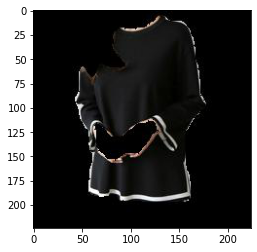

In [57]:
filename = "/content/121157_상의.jpg"

img = Image.open(filename).convert('RGB')

plt.imshow(img)

if val_transform is not None:
    
    img = val_transform(img)


img = img.unsqueeze(0)

feature_var = torch.autograd.Variable(img).float()

model.eval()

output = model(feature_var)
percentage_output = F.softmax(output, dim = 1)


pred = output.cpu().detach().numpy()

sorted_pred = np.argsort(pred,axis = 1)

for i in range(20,-1,-1):
    
    print(f"top {21-i}: {change_category[sorted_pred[0][i]]}, conf:{percentage_output[0][sorted_pred[0][i]]*100:.4f}")

In [36]:
sorted_pred

array([[16,  7, 19, 13, 12, 10, 20,  1, 15,  2, 18, 14,  4,  5,  0, 11,
        17,  6,  9,  8,  3]])